In [1]:
# Author: Caleb Woy

import numpy as np # linear algebra
import pandas as pd # data processing
from scipy.stats import kurtosis, skew # checking distributions
import scipy.stats as stat # plotting, mostly
import matplotlib.pyplot as pl # plotting
import seaborn as sb # plotting
import os

# So we can see some interesting output without truncation
pd.options.display.max_rows = 1000

path_to_data = "C:/Users/woybo/Desktop/Jupyter-Nbooks/1994Census"

# Loading the training and test data sets into pandas
train_original = pd.read_csv(path_to_data + "/adult.data", names=['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                                                                  'marital-status', 'occupation', 'relationship', 'race', 'sex',
                                                                  'cap-gain', 'cap-loss', 'hrsperwk', 'native', 'label'])
test_original = pd.read_csv(path_to_data + "/adult.test", skiprows=1, names=['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                                                                             'marital-status', 'occupation', 'relationship', 'race', 'sex',
                                                                             'cap-gain', 'cap-loss', 'hrsperwk', 'native', 'label'])

# Combining the training and test sets
frames = [train_original, test_original]
data_original = pd.concat(frames)

# print the head
data_original.head()

age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   cap-gain  cap-loss  hrsperwk          native   label  
0      2174         0        40   United-States   <=50K  
1         0         0        13   United-States   <=50K  
2         0         0        40   United-States   <=50K  
3         0         0        40   United-States   <=50K  
4         0         0        40            Cuba   <=50K

# ***Business Understanding***

Recorded originally by the US census bureau for the purpose of determining the correct number of House representatives per state via the 1990 census survey. Extracted by from the 1994 census database by Barry Becker under the following conditions: "((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))." Each record represents a single American Citizen that is > 16 years of age, has a difference between their Total income and Adjustments to income of > 100, has a fnlwgt attribute > 1, and works more than 0 hours per week.

The data set has been curated as a sample of the working population in the United States, for the purpose of predicting whether an individual makes > 50K per year. 

The feature "fnlwgt" was added by the dataset authors as a controlled estimate of certain socio-economic effects that take individual state population distributions into account. The controls accounted for are:

    | 1.  A single cell estimate of the population 16+ for each state.
    | 2.  Controls for Hispanic Origin by age and sex.
    | 3.  Controls by Race, age and sex.
    
Original data converted, by the data set authors, as follows:

    | 1. Discretized agrossincome into two ranges with threshold 50,000.
    | 2. Convert U.S. to US to avoid periods.
    | 3. Convert Unknown to "?"
    | 4. Run MLC++ GenCVFiles to generate data,test.
    
Here, numerical data (gross income) was simplified into binary categories of > 50K or <= 50K. MLC++ GenCVFiles is used to randomly split the data into training and tesing set for the purpose of ML application.

I have edited the files adult.data and adult.test to include column names.

# ***__Data Understanding & Data Processing__***

#######################################################################################################################################################

### **label**:     /Categorical. Factor levels include: > 50K, <= 50K

Meaning: whether the indiviual makes more or less than 50K per year

In [2]:
feature_name = 'label'

# Checking counts per designation
data_original.groupby(feature_name).count()

age  workclass  fnlwgt  education  education-num  marital-status  \
label                                                                         
 <=50K   24720      24720   24720      24720          24720           24720   
 <=50K.  12435      12435   12435      12435          12435           12435   
 >50K     7841       7841    7841       7841           7841            7841   
 >50K.    3846       3846    3846       3846           3846            3846   

         occupation  relationship   race    sex  cap-gain  cap-loss  hrsperwk  \
label                                                                           
 <=50K        24720         24720  24720  24720     24720     24720     24720   
 <=50K.       12435         12435  12435  12435     12435     12435     12435   
 >50K          7841          7841   7841   7841      7841      7841      7841   
 >50K.         3846          3846   3846   3846      3846      3846      3846   

         native  
label            
 <=50K    24720  
 <=50K.   12435  
 >50K      7841  
 >50K.     3846

In [3]:
# the output here is erroneously grouped into 4 rows, I need to remove the period from every label in the test set to get an accurate count.
data_original[[feature_name]] = data_original[[feature_name]].replace([" <=50K.", " >50K."], [" <=50K", " >50K"])
data_original.groupby(feature_name).count()

age  workclass  fnlwgt  education  education-num  marital-status  \
label                                                                        
 <=50K  37155      37155   37155      37155          37155           37155   
 >50K   11687      11687   11687      11687          11687           11687   

        occupation  relationship   race    sex  cap-gain  cap-loss  hrsperwk  \
label                                                                          
 <=50K       37155         37155  37155  37155     37155     37155     37155   
 >50K        11687         11687  11687  11687     11687     11687     11687   

        native  
label           
 <=50K   37155  
 >50K    11687

In [4]:
# better, now we can view a summary
data_original[[feature_name]].describe()

label
count    48842
unique       2
top      <=50K
freq     37155

In [5]:
# So, there are 48842 values in the label column. There are 2 factor levels for the column. The most common label is '<= 50K' and it occurs 37155 times, 
# roughly 3/4 of the individuals.
# Now we'll check for missing values.
boolseries = data_original.apply(lambda x: True if x[feature_name] == ' ?' else False, axis=1)
print(f'Number of missing values (?): {len(boolseries[boolseries == True].index)}')
print(f'Number of null values: {data_original[[feature_name]].isnull().sum()}')

Number of missing values (?): 0
Number of null values: label    0
dtype: int64


In [6]:
# No missing values for our label, that's good. I'll move onto the next feature.

#######################################################################################################################################################

### **age**    /Continuous. 

Meaning: the integer value age of the individual

In [7]:
feature_name = 'age'

# viewing a summary
data_original[[feature_name]].describe()

age
count  48842.000000
mean      38.643585
std       13.710510
min       17.000000
25%       28.000000
50%       37.000000
75%       48.000000
max       90.000000

In [8]:
#checking for missing values
boolseries = data_original.apply(lambda x: True if x[feature_name] == ' ?' else False, axis=1)
print(f'Number of missing values (?): {len(boolseries[boolseries == True].index)}')
print(f'Number of null values: {data_original[[feature_name]].isnull().sum()}')

Number of missing values (?): 0
Number of null values: age    0
dtype: int64


In [9]:
# No missing values on age, let's check skewness and kurtosis
print(f'Skewness: {skew(data_original.age)}')
print(f'Kurtosis: {kurtosis(data_original.age)}')

Skewness: 0.5575631924658626
Kurtosis: -0.18437271998309956


Text(0, 0.5, 'Frequency')

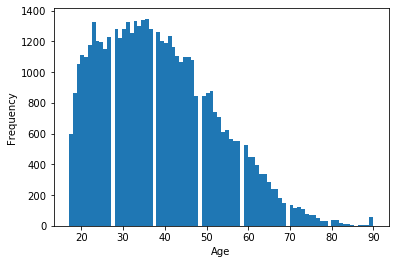

In [10]:
# The sample distribution of ages appears to be slightly right skewed with very slight negative kurtosis. This may need transformed for future modelling.
# Let's visualize this one to confirm the skewness.
x = data_original.age
pl.hist(x, bins=80)
pl.xlabel('Age')
pl.ylabel('Frequency')

workclass  fnlwgt   education  education-num       marital-status  \
0          State-gov   77516   Bachelors             13        Never-married   
1   Self-emp-not-inc   83311   Bachelors             13   Married-civ-spouse   
2            Private  215646     HS-grad              9             Divorced   
3            Private  234721        11th              7   Married-civ-spouse   
4            Private  338409   Bachelors             13   Married-civ-spouse   

           occupation    relationship    race      sex  cap-gain  cap-loss  \
0        Adm-clerical   Not-in-family   White     Male      2174         0   
1     Exec-managerial         Husband   White     Male         0         0   
2   Handlers-cleaners   Not-in-family   White     Male         0         0   
3   Handlers-cleaners         Husband   Black     Male         0         0   
4      Prof-specialty            Wife   Black   Female         0         0   

   hrsperwk          native   label  log_age_ZCentered  
0        40   United-States   <=50K           0.201990  
1        13   United-States   <=50K           0.888830  
2        40   United-States   <=50K           0.130184  
3        40   United-States   <=50K           1.049907  
4        40            Cuba   <=50K          -0.714005

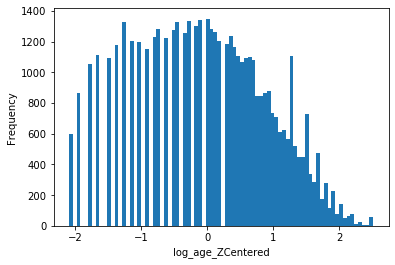

In [11]:
# The values at the end of the right tail are definitely outliers however they're meaningful in our analysis (the elderly are important too). There don't appear to be any obvious
# errors caused by typos (like 500 or 0) 

# I'll create a new feature by taking the log and centering with the z score

logage = np.log(data_original['age'])

mean = np.mean(logage)
stdev = np.std(logage)
data_original['log_age_ZCentered'] = (logage - mean) / stdev

x = data_original['log_age_ZCentered']
pl.hist(x, bins=80)
pl.xlabel('log_age_ZCentered')
pl.ylabel('Frequency')

# removing the original age feature
del data_original['age']

# checking for success
data_original.head()

#all good

#######################################################################################################################################################

### **workclass**    /Categorical. Factor levels include: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
                  
Meaning: This feature explains the general category of the economy the individual works within.

In [12]:
feature_name = 'workclass'

# viewing a summary
data_original[[feature_name]].describe()

workclass
count      48842
unique         9
top      Private
freq       33906

In [13]:
# Roughly 3/4 of our individuals appear to be working in the private sector. Describe returned that there are 9 factor levels in this feature when we know there are actually 
# only 8. so there must be missing values in this feature. Let's check.

boolseries = data_original.apply(lambda x: True if x[feature_name] == ' ?' else False, axis=1)
print(f'Number of missing values (?): {len(boolseries[boolseries == True].index)}')
print(f'Number of null values: {data_original[[feature_name]].isnull().sum()}')


Number of missing values (?): 2799
Number of null values: workclass    0
dtype: int64


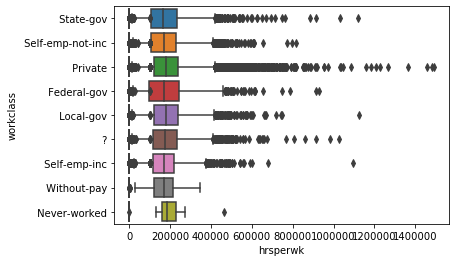

In [14]:
# There are 2799 ? values currently. None of them are Null or NaN values, so that's good. We have a few options here. The first is to impute the mode level (Private). 
# The second is to check if there are any other features here that might explain variation in with workclass, then if so, predict the missing workclass values. The third is 
# leave the ? value in as a placeholder unkown value and predict based on the effect of the level as we would any other feature.

# I'll make some boxplots to see if there's any explainable variation.

sb.boxplot( x=data_original["log_age_ZCentered"], y=data_original["workclass"] )
sb.boxplot( x=data_original["fnlwgt"], y=data_original["workclass"] )
sb.boxplot( x=data_original["education-num"], y=data_original["workclass"] )
sb.boxplot( x=data_original["cap-gain"], y=data_original["workclass"] )
sb.boxplot( x=data_original["cap-loss"], y=data_original["workclass"] )
sb.boxplot( x=data_original["hrsperwk"], y=data_original["workclass"] )

In [15]:
# None of these give off the appearance of explainatory variation that I'm looking to test with ANOVA so I'll impute the mode (Private) for the missing values. This can
# always be undone later during the modelling fase should we like to check how well we can predict with an unkown value effect.

# Checking the original counts at each factor level
data_original.groupby(feature_name).count()

# Making the replacement and recalculating the values
data_original[[feature_name]] = data_original[[feature_name]].replace([" ?"], [" Private"])
data_original.groupby(feature_name).count()

# All good.

fnlwgt  education  education-num  marital-status  \
workclass                                                             
 Federal-gov         1432       1432           1432            1432   
 Local-gov           3136       3136           3136            3136   
 Never-worked          10         10             10              10   
 Private            36705      36705          36705           36705   
 Self-emp-inc        1695       1695           1695            1695   
 Self-emp-not-inc    3862       3862           3862            3862   
 State-gov           1981       1981           1981            1981   
 Without-pay           21         21             21              21   

                   occupation  relationship   race    sex  cap-gain  cap-loss  \
workclass                                                                       
 Federal-gov             1432          1432   1432   1432      1432      1432   
 Local-gov               3136          3136   3136   3136      3136      3136   
 Never-worked              10            10     10     10        10        10   
 Private                36705         36705  36705  36705     36705     36705   
 Self-emp-inc            1695          1695   1695   1695      1695      1695   
 Self-emp-not-inc        3862          3862   3862   3862      3862      3862   
 State-gov               1981          1981   1981   1981      1981      1981   
 Without-pay               21            21     21     21        21        21   

                   hrsperwk  native  label  log_age_ZCentered  
workclass                                                      
 Federal-gov           1432    1432   1432               1432  
 Local-gov             3136    3136   3136               3136  
 Never-worked            10      10     10                 10  
 Private              36705   36705  36705              36705  
 Self-emp-inc          1695    1695   1695               1695  
 Self-emp-not-inc      3862    3862   3862               3862  
 State-gov             1981    1981   1981               1981  
 Without-pay             21      21     21                 21

#######################################################################################################################################################

### **fnlwgt**    /Continuous. 

Meaning: The feature "fnlwgt" was added by the dataset authors as a controlled estimate of certain socio-economic effects that take individual state population distributions into account.

In [16]:
feature_name = 'fnlwgt'

# viewing a summary
data_original[[feature_name]].describe()

fnlwgt
count  4.884200e+04
mean   1.896641e+05
std    1.056040e+05
min    1.228500e+04
25%    1.175505e+05
50%    1.781445e+05
75%    2.376420e+05
max    1.490400e+06

In [17]:
# These are large numbers, any predictive model we apply on this data set would befit from some regularization here in the future. The max is exponetially larger than the mean.
# High values in fnlwgt will need investigated.

# Let's check for missing values.
boolseries = data_original.apply(lambda x: True if x[feature_name] == ' ?' else False, axis=1)
print(f'Number of missing values (?): {len(boolseries[boolseries == True].index)}')
print(f'Number of null values: {data_original[[feature_name]].isnull().sum()}')

Number of missing values (?): 0
Number of null values: fnlwgt    0
dtype: int64


In [18]:
# None, the data set authors created this feature so that should have been expected. Thanks authors!

# Checking skewness and kurtosis.
print(f'Skewness: {skew(data_original[feature_name])}')
print(f'Kurtosis: {kurtosis(data_original[feature_name])}')

Skewness: 1.438847687943433
Kurtosis: 6.057105240227166


Text(0, 0.5, 'Frequency')

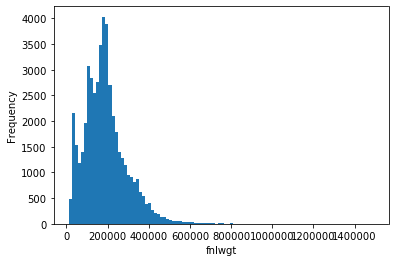

In [19]:
# The fnlwgt column has some strong right skew and high positive kurtosis. It should look like a big spike on the left side of the distribution.

# Let's visualize to confirm.
x = data_original[feature_name]
pl.hist(x, bins=100)
pl.xlabel('fnlwgt')
pl.ylabel('Frequency')


workclass   education  education-num       marital-status  \
0          State-gov   Bachelors             13        Never-married   
1   Self-emp-not-inc   Bachelors             13   Married-civ-spouse   
2            Private     HS-grad              9             Divorced   
3            Private        11th              7   Married-civ-spouse   
4            Private   Bachelors             13   Married-civ-spouse   

           occupation    relationship    race      sex  cap-gain  cap-loss  \
0        Adm-clerical   Not-in-family   White     Male      2174         0   
1     Exec-managerial         Husband   White     Male         0         0   
2   Handlers-cleaners   Not-in-family   White     Male         0         0   
3   Handlers-cleaners         Husband   Black     Male         0         0   
4      Prof-specialty            Wife   Black   Female         0         0   

   hrsperwk          native   label  log_age_ZCentered  log_fnl_wgt_ZCentered  
0        40   United-States   <=50K           0.201990              -1.148845  
1        13   United-States   <=50K           0.888830              -1.034554  
2        40   United-States   <=50K           0.130184               0.473106  
3        40   United-States   <=50K           1.049907               0.607470  
4        40            Cuba   <=50K          -0.714005               1.187445

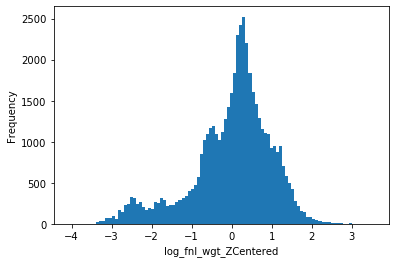

In [20]:
# Yup. This feature would benefit from a log transformation. 

# Creating a new feature. I'll take the log transoform then standardize that using the z-score.
logfnlwgt = np.log(data_original['fnlwgt'])

mean = np.mean(logfnlwgt)
stdev = np.std(logfnlwgt)
data_original['log_fnl_wgt_ZCentered'] = (logfnlwgt - mean) / stdev

x = data_original['log_fnl_wgt_ZCentered']
pl.hist(x, bins=100)
pl.xlabel('log_fnl_wgt_ZCentered')
pl.ylabel('Frequency')

# removing the original fnlwgt feature
del data_original['fnlwgt']

# checking for success
data_original.head()

# all good

In [21]:
#Let's view the largest values of the distribution. 
data_original.nlargest(10, ['log_fnl_wgt_ZCentered']) 

workclass      education  education-num          marital-status  \
7974      Private   Some-college             10      Married-civ-spouse   
14449     Private   Some-college             10                Divorced   
18138     Private     Assoc-acdm             12               Separated   
16739     Private      Assoc-voc             11                Divorced   
15569     Private        HS-grad              9   Married-spouse-absent   
8258      Private      Bachelors             13      Married-civ-spouse   
14523     Private           10th              6      Married-civ-spouse   
5369      Private   Some-college             10      Married-civ-spouse   
25075     Private   Some-college             10               Separated   
29164   Local-gov        HS-grad              9                Divorced   

              occupation    relationship    race      sex  cap-gain  cap-loss  \
7974     Exec-managerial         Husband   White     Male         0         0   
14449    Exec-managerial       Unmarried   White   Female         0         0   
18138       Craft-repair   Not-in-family   White     Male         0         0   
16739      Other-service   Not-in-family   White   Female         0         0   
15569       Tech-support       Own-child   Black     Male         0         0   
8258               Sales         Husband   White     Male         0         0   
14523       Adm-clerical            Wife   White   Female         0         0   
5369    Transport-moving         Husband   Black     Male         0         0   
25075       Tech-support       Unmarried   White   Female         0         0   
29164      Other-service   Not-in-family   Black     Male         0         0   

       hrsperwk          native   label  log_age_ZCentered  \
7974         40   United-States   <=50K          -0.814539   
14449        25   United-States   <=50K          -1.027288   
18138        40   United-States   <=50K           0.201990   
16739         8   United-States   <=50K           0.597574   
15569        40   United-States   <=50K          -0.616999   
8258         52   United-States    >50K          -0.097153   
14523        40   United-States   <=50K          -0.432639   
5369         35   United-States   <=50K          -0.523283   
25075        50        Columbia   <=50K          -0.259810   
29164        40   United-States   <=50K           0.406852   

       log_fnl_wgt_ZCentered  
7974                3.537642  
14449               3.531573  
18138               3.500009  
16739               3.399615  
15569               3.281884  
8258                3.228817  
14523               3.207899  
5369                3.173637  
25075               3.142202  
29164               3.092637

In [22]:
# Regarding the outliers at the tail of fnlwgt, none of these appear to be abnormal. We can't know forsure 
# without knowing how fnlwgt was calulated, yet the consistent increasing of the feature values up to the max appears systematic and not erroneous. I won't do anything
# special about them.

#######################################################################################################################################################

### **Education**    /Categorical. Factor levels include: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
                  
Meaning: How much schooling the individual has completed.

In [23]:
feature_name = 'education'

# viewing a summary
data_original[[feature_name]].describe()

education
count      48842
unique        16
top      HS-grad
freq       15784

In [24]:
# Seeing the correct number of unique factor levels here so likely no missing values. HS-grad is the most common level
# Let's confirm:

boolseries = data_original.apply(lambda x: True if x[feature_name] == ' ?' else False, axis=1)
print(f'Number of missing values (?): {len(boolseries[boolseries == True].index)}')
print(f'Number of null values: {data_original[[feature_name]].isnull().sum()}')

Number of missing values (?): 0
Number of null values: education    0
dtype: int64


In [25]:
# Yup. Looking good here.

#######################################################################################################################################################

### **education-num**    /continuous. 

Meaning: The number of years of education completed by and individual.

In [26]:
feature_name = 'education-num'

# viewing a summary
data_original[[feature_name]].describe()

education-num
count   48842.000000
mean       10.078089
std         2.570973
min         1.000000
25%         9.000000
50%        10.000000
75%        12.000000
max        16.000000

In [27]:
# Mean value of ~10. Max and min are prestty evenly spread.
# Checking for missing values:

boolseries = data_original.apply(lambda x: True if x[feature_name] == ' ?' else False, axis=1)
print(f'Number of missing values (?): {len(boolseries[boolseries == True].index)}')
print(f'Number of null values: {data_original[[feature_name]].isnull().sum()}')

Number of missing values (?): 0
Number of null values: education-num    0
dtype: int64


In [28]:
# Let's look at the skewness and kurtosis:

print(f'Skewness: {skew(data_original[feature_name])}')
print(f'Kurtosis: {kurtosis(data_original[feature_name])}')

Skewness: -0.3165151356965018
Kurtosis: 0.6255583739336319


Text(0, 0.5, 'Frequency')

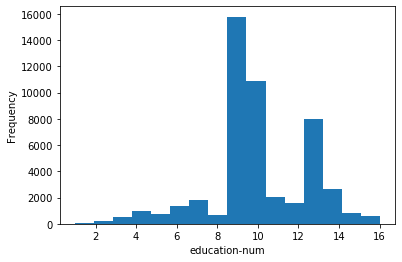

In [29]:
# Slight positive kurtosis, slight left skew. Let's visualize:

x = data_original[feature_name]
pl.hist(x, bins=16)
pl.xlabel('education-num')
pl.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

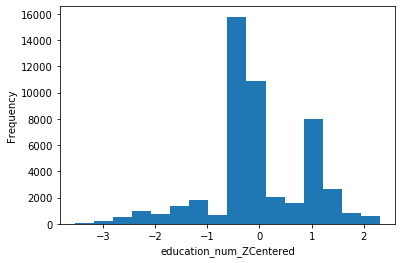

In [30]:
# This distribution appears bimodal. Likely due to the effect of college. This might make the categorical feature (education) more useful to us.

# I'll scale this by transforming it with the Z-score.

mean = np.mean(data_original[feature_name])
stdev = np.std(data_original[feature_name])
education_num_ZCentered = (data_original[feature_name] - mean) / stdev

# Visualizing:
x = education_num_ZCentered
pl.hist(x, bins=16)
pl.xlabel('education_num_ZCentered')
pl.ylabel('Frequency')

In [31]:
# Now to replace the original feature with the transformed version.

data_original['education_num_ZCentered'] = education_num_ZCentered

# Deleting the original:
del data_original[feature_name]

# Checking:
data_original.head()

workclass   education       marital-status          occupation  \
0          State-gov   Bachelors        Never-married        Adm-clerical   
1   Self-emp-not-inc   Bachelors   Married-civ-spouse     Exec-managerial   
2            Private     HS-grad             Divorced   Handlers-cleaners   
3            Private        11th   Married-civ-spouse   Handlers-cleaners   
4            Private   Bachelors   Married-civ-spouse      Prof-specialty   

     relationship    race      sex  cap-gain  cap-loss  hrsperwk  \
0   Not-in-family   White     Male      2174         0        40   
1         Husband   White     Male         0         0        13   
2   Not-in-family   White     Male         0         0        40   
3         Husband   Black     Male         0         0        40   
4            Wife   Black   Female         0         0        40   

           native   label  log_age_ZCentered  log_fnl_wgt_ZCentered  \
0   United-States   <=50K           0.201990              -1.148845   
1   United-States   <=50K           0.888830              -1.034554   
2   United-States   <=50K           0.130184               0.473106   
3   United-States   <=50K           1.049907               0.607470   
4            Cuba   <=50K          -0.714005               1.187445   

   education_num_ZCentered  
0                 1.136512  
1                 1.136512  
2                -0.419335  
3                -1.197259  
4                 1.136512

#######################################################################################################################################################

### **marital-status**    /Categorical. Factor-levels include: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse
                       
Meaning: Whether the individual is married or divorced, etc. Interesting because houses with two income sources will be different than one.

In [32]:
feature_name = 'marital-status'

# viewing a summary
data_original[[feature_name]].describe()

marital-status
count                 48842
unique                    7
top      Married-civ-spouse
freq                  22379

In [33]:
# There are 7 unique factor levels present in our distribution. So, likely no missing values. We can confirm.

boolseries = data_original.apply(lambda x: True if x[feature_name] == ' ?' else False, axis=1)
print(f'Number of missing values (?): {len(boolseries[boolseries == True].index)}')
print(f'Number of null values: {data_original[[feature_name]].isnull().sum()}')

Number of missing values (?): 0
Number of null values: marital-status    0
dtype: int64


#######################################################################################################################################################

### **occupation**    /Categorical. Factor-levels include: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces
                       
Meaning: The field in which the individual works.

In [34]:
feature_name = 'occupation'

# viewing a summary
data_original[[feature_name]].describe()

occupation
count             48842
unique               15
top      Prof-specialty
freq               6172

In [35]:
# There are only supposed to be 14 factor levels so they're definitely some missing values here.

boolseries = data_original.apply(lambda x: True if x[feature_name] == ' ?' else False, axis=1)
print(f'Number of missing values (?): {len(boolseries[boolseries == True].index)}')
print(f'Number of null values: {data_original[[feature_name]].isnull().sum()}')

Number of missing values (?): 2809
Number of null values: occupation    0
dtype: int64


In [36]:
# 2809 missing values. I'll impute the mode value (Prof-specialty)

data_original.groupby(feature_name).count()

# Making the replacement and recalculating the values
data_original[[feature_name]] = data_original[[feature_name]].replace([" ?"], [" Prof-specialty"])
data_original.groupby(feature_name).count()

# Worked fine.

workclass  education  marital-status  relationship  race  \
occupation                                                                     
 Adm-clerical            5611       5611            5611          5611  5611   
 Armed-Forces              15         15              15            15    15   
 Craft-repair            6112       6112            6112          6112  6112   
 Exec-managerial         6086       6086            6086          6086  6086   
 Farming-fishing         1490       1490            1490          1490  1490   
 Handlers-cleaners       2072       2072            2072          2072  2072   
 Machine-op-inspct       3022       3022            3022          3022  3022   
 Other-service           4923       4923            4923          4923  4923   
 Priv-house-serv          242        242             242           242   242   
 Prof-specialty          8981       8981            8981          8981  8981   
 Protective-serv          983        983             983           983   983   
 Sales                   5504       5504            5504          5504  5504   
 Tech-support            1446       1446            1446          1446  1446   
 Transport-moving        2355       2355            2355          2355  2355   

                     sex  cap-gain  cap-loss  hrsperwk  native  label  \
occupation                                                              
 Adm-clerical       5611      5611      5611      5611    5611   5611   
 Armed-Forces         15        15        15        15      15     15   
 Craft-repair       6112      6112      6112      6112    6112   6112   
 Exec-managerial    6086      6086      6086      6086    6086   6086   
 Farming-fishing    1490      1490      1490      1490    1490   1490   
 Handlers-cleaners  2072      2072      2072      2072    2072   2072   
 Machine-op-inspct  3022      3022      3022      3022    3022   3022   
 Other-service      4923      4923      4923      4923    4923   4923   
 Priv-house-serv     242       242       242       242     242    242   
 Prof-specialty     8981      8981      8981      8981    8981   8981   
 Protective-serv     983       983       983       983     983    983   
 Sales              5504      5504      5504      5504    5504   5504   
 Tech-support       1446      1446      1446      1446    1446   1446   
 Transport-moving   2355      2355      2355      2355    2355   2355   

                    log_age_ZCentered  log_fnl_wgt_ZCentered  \
occupation                                                     
 Adm-clerical                    5611                   5611   
 Armed-Forces                      15                     15   
 Craft-repair                    6112                   6112   
 Exec-managerial                 6086                   6086   
 Farming-fishing                 1490                   1490   
 Handlers-cleaners               2072                   2072   
 Machine-op-inspct               3022                   3022   
 Other-service                   4923                   4923   
 Priv-house-serv                  242                    242   
 Prof-specialty                  8981                   8981   
 Protective-serv                  983                    983   
 Sales                           5504                   5504   
 Tech-support                    1446                   1446   
 Transport-moving                2355                   2355   

                    education_num_ZCentered  
occupation                                   
 Adm-clerical                          5611  
 Armed-Forces                            15  
 Craft-repair                          6112  
 Exec-managerial                       6086  
 Farming-fishing                       1490  
 Handlers-cleaners                     2072  
 Machine-op-inspct                     3022  
 Other-service                         4923  
 Priv-house-serv                        242  
 Prof-specialty                        

#######################################################################################################################################################

### **relationship**    /Categorical. Factor Values: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
                     
Meaning: The type of relationship the individual is in.

In [37]:
feature_name = 'relationship'

# viewing a summary
data_original[[feature_name]].describe()

relationship
count         48842
unique            6
top         Husband
freq          19716

In [38]:
# Seeing 6 unique factor levels as expected. Most common level is Husband.
# Confirming no missing values

boolseries = data_original.apply(lambda x: True if x[feature_name] == ' ?' else False, axis=1)
print(f'Number of missing values (?): {len(boolseries[boolseries == True].index)}')
print(f'Number of null values: {data_original[[feature_name]].isnull().sum()}')

Number of missing values (?): 0
Number of null values: relationship    0
dtype: int64


In [39]:
# Good.

#######################################################################################################################################################

### **race**    /Categorical. Factor levels include: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
             
Meaning: The race of the individual.

In [40]:
feature_name = 'race'

# viewing a summary
data_original[[feature_name]].describe()

race
count    48842
unique       5
top      White
freq     41762

In [41]:
# Seeing 5 unique factor levels as expected. Most common level is White.
# Confirming no missing values

boolseries = data_original.apply(lambda x: True if x[feature_name] == ' ?' else False, axis=1)
print(f'Number of missing values (?): {len(boolseries[boolseries == True].index)}')
print(f'Number of null values: {data_original[[feature_name]].isnull().sum()}')

Number of missing values (?): 0
Number of null values: race    0
dtype: int64


In [42]:
# Good.

#######################################################################################################################################################

### **sex**    /Categorical. Factor levels include: Female, Male. 

Meaning: The sex of the individual.

In [43]:
feature_name = 'sex'

# viewing a summary
data_original[[feature_name]].describe()

sex
count   48842
unique      2
top      Male
freq    32650

In [44]:
# Seeing 2 unique factor levels as expected. Most common level is Male.
# Confirming no missing values

boolseries = data_original.apply(lambda x: True if x[feature_name] == ' ?' else False, axis=1)
print(f'Number of missing values (?): {len(boolseries[boolseries == True].index)}')
print(f'Number of null values: {data_original[[feature_name]].isnull().sum()}')

Number of missing values (?): 0
Number of null values: sex    0
dtype: int64


In [45]:
# Good.

#######################################################################################################################################################

### **cap-gain**    /Continuous. 

Meaning: Dollars gained by the individual's investments during the year.

In [46]:
feature_name = 'cap-gain'

# viewing a summary
data_original[[feature_name]].describe()

cap-gain
count  48842.000000
mean    1079.067626
std     7452.019058
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max    99999.000000

In [47]:
# The summary here tells us the mean gain is about a thousand dollars. The distribution appears to be dramatically right skewed and is likely mostly (0) values.
# Let's comfirm by checking skew and kurtosis.

print(f'Skewness: {skew(data_original[feature_name])}')
print(f'Kurtosis: {kurtosis(data_original[feature_name])}')

Skewness: 11.894293693350868
Kurtosis: 152.6773425724958


In [48]:
# Yeah . . . we'll be transforming this one. First, Let's check for missing values.

boolseries = data_original.apply(lambda x: True if x[feature_name] == ' ?' else False, axis=1)
print(f'Number of missing values (?): {len(boolseries[boolseries == True].index)}')
print(f'Number of null values: {data_original[[feature_name]].isnull().sum()}')

Number of missing values (?): 0
Number of null values: cap-gain    0
dtype: int64


Text(0, 0.5, 'Frequency')

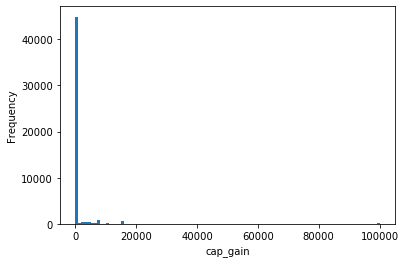

In [49]:
# None. That's helpful. Time to visualize this one.

x = data_original[feature_name]
pl.hist(x, bins=100)
pl.xlabel('cap_gain')
pl.ylabel('Frequency')

In [50]:
# Before I transform this, I want to investigate the outlier here that's near 100K.

data_original.nlargest(10, [feature_name]) 

# I've actually viewed the top 60 largest values here but I set the code back to outputting the top 10 to keep this report cleaner.
# The trend shown in the top 10 is the same as the top 60, all are labeled > 50k. 

workclass      education       marital-status        occupation  \
1246       Self-emp-inc    Prof-school   Married-civ-spouse    Prof-specialty   
1368            Private        HS-grad   Married-civ-spouse   Exec-managerial   
1482       Self-emp-inc        HS-grad   Married-civ-spouse             Sales   
1528            Private      Bachelors   Married-civ-spouse   Exec-managerial   
1616            Private    Prof-school   Married-civ-spouse    Prof-specialty   
1682            Private      Bachelors   Married-civ-spouse   Exec-managerial   
1765            Private      Bachelors   Married-civ-spouse    Prof-specialty   
1771            Private   Some-college   Married-civ-spouse   Exec-managerial   
1826   Self-emp-not-inc        HS-grad        Never-married    Prof-specialty   
2103       Self-emp-inc   Some-college   Married-civ-spouse             Sales   

     relationship                 race      sex  cap-gain  cap-loss  hrsperwk  \
1246      Husband                White     Male     99999         0        60   
1368      Husband   Asian-Pac-Islander     Male     99999         0        40   
1482      Husband                White     Male     99999         0        40   
1528      Husband                White     Male     99999         0        50   
1616      Husband                White     Male     99999         0        60   
1682      Husband                White     Male     99999         0        60   
1765         Wife                White   Female     99999         0        20   
1771      Husband                White     Male     99999         0        50   
1826    Unmarried                White   Female     99999         0        40   
2103      Husband                White     Male     99999         0        55   

                   native  label  log_age_ZCentered  log_fnl_wgt_ZCentered  \
1246        United-States   >50K           1.101579               0.062703   
1368                Japan   >50K           0.997251              -0.078908   
1482        United-States   >50K           1.049907               0.793368   
1528        United-States   >50K           0.997251              -0.482388   
1616        United-States   >50K           0.658332               1.329434   
1682        United-States   >50K           0.471899               0.153486   
1765        United-States   >50K           0.832982              -0.001858   
1771        United-States   >50K           0.888830               0.108499   
1826   Dominican-Republic   >50K          -1.380667               0.376681   
2103        United-States   >50K           0.471899               0.122207   

      education_num_ZCentered  
1246                 1.914436  
1368                -0.419335  
1482                -0.419335  
1528                 1.136512  
1616                 1.914436  
1682                 1.136512  
1765                 1.136512  
1771                -0.030373  
1826                -0.419335  
2103                -0.030373

In [51]:
# I think I want to create a new feature here. A simple binary feature specifying whether the individual made > 50K in capital gains alone.

data_original['cap-gains50k'] = data_original.apply(lambda x: True if x[feature_name] > 50000 else False, axis=1).astype('category')

# Checking that it worked:
data_original.nlargest(10, [feature_name]) 

workclass      education       marital-status        occupation  \
1246       Self-emp-inc    Prof-school   Married-civ-spouse    Prof-specialty   
1368            Private        HS-grad   Married-civ-spouse   Exec-managerial   
1482       Self-emp-inc        HS-grad   Married-civ-spouse             Sales   
1528            Private      Bachelors   Married-civ-spouse   Exec-managerial   
1616            Private    Prof-school   Married-civ-spouse    Prof-specialty   
1682            Private      Bachelors   Married-civ-spouse   Exec-managerial   
1765            Private      Bachelors   Married-civ-spouse    Prof-specialty   
1771            Private   Some-college   Married-civ-spouse   Exec-managerial   
1826   Self-emp-not-inc        HS-grad        Never-married    Prof-specialty   
2103       Self-emp-inc   Some-college   Married-civ-spouse             Sales   

     relationship                 race      sex  cap-gain  cap-loss  hrsperwk  \
1246      Husband                White     Male     99999         0        60   
1368      Husband   Asian-Pac-Islander     Male     99999         0        40   
1482      Husband                White     Male     99999         0        40   
1528      Husband                White     Male     99999         0        50   
1616      Husband                White     Male     99999         0        60   
1682      Husband                White     Male     99999         0        60   
1765         Wife                White   Female     99999         0        20   
1771      Husband                White     Male     99999         0        50   
1826    Unmarried                White   Female     99999         0        40   
2103      Husband                White     Male     99999         0        55   

                   native  label  log_age_ZCentered  log_fnl_wgt_ZCentered  \
1246        United-States   >50K           1.101579               0.062703   
1368                Japan   >50K           0.997251              -0.078908   
1482        United-States   >50K           1.049907               0.793368   
1528        United-States   >50K           0.997251              -0.482388   
1616        United-States   >50K           0.658332               1.329434   
1682        United-States   >50K           0.471899               0.153486   
1765        United-States   >50K           0.832982              -0.001858   
1771        United-States   >50K           0.888830               0.108499   
1826   Dominican-Republic   >50K          -1.380667               0.376681   
2103        United-States   >50K           0.471899               0.122207   

      education_num_ZCentered cap-gains50k  
1246                 1.914436         True  
1368                -0.419335         True  
1482                -0.419335         True  
1528                 1.136512         True  
1616                 1.914436         True  
1682                 1.136512         True  
1765                 1.136512         True  
1771                -0.030373         True  
1826                -0.419335         True  
2103                -0.030373         True

Text(0, 0.5, 'Frequency')

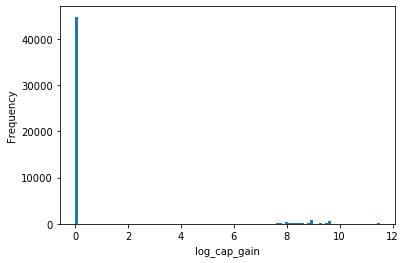

In [52]:
# That should be a really significant factor in whatever model we might use to predict our label.
# Now I'll transform the original cap-gain feature. Taking a log of 0 will produce NaNs so I'll transform the feature to log(cap-gains + 1) and then I'll scale It with the z-score.

log_cap_gain = np.log(data_original[feature_name] + 1)

# Visualizing:
x = log_cap_gain
pl.hist(x, bins=100)
pl.xlabel('log_cap_gain')
pl.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

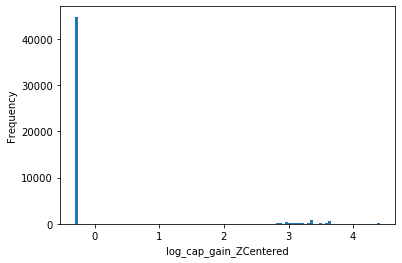

In [53]:
# Now scaling by Z-score:

mean = np.mean(log_cap_gain)
stdev = np.std(log_cap_gain)
log_cap_gain_ZCentered = (log_cap_gain - mean) / stdev

# Visualizing:
x = log_cap_gain_ZCentered
pl.hist(x, bins=100)
pl.xlabel('log_cap_gain_ZCentered')
pl.ylabel('Frequency')

In [54]:
# Now to replace the original feature with the transformed version.

data_original['log_cap_gain_ZCentered'] = log_cap_gain_ZCentered

# Deleting the original:
del data_original[feature_name]

# Checking:
data_original.head()

workclass   education       marital-status          occupation  \
0          State-gov   Bachelors        Never-married        Adm-clerical   
1   Self-emp-not-inc   Bachelors   Married-civ-spouse     Exec-managerial   
2            Private     HS-grad             Divorced   Handlers-cleaners   
3            Private        11th   Married-civ-spouse   Handlers-cleaners   
4            Private   Bachelors   Married-civ-spouse      Prof-specialty   

     relationship    race      sex  cap-loss  hrsperwk          native  \
0   Not-in-family   White     Male         0        40   United-States   
1         Husband   White     Male         0        13   United-States   
2   Not-in-family   White     Male         0        40   United-States   
3         Husband   Black     Male         0        40   United-States   
4            Wife   Black   Female         0        40            Cuba   

    label  log_age_ZCentered  log_fnl_wgt_ZCentered  education_num_ZCentered  \
0   <=50K           0.201990              -1.148845                 1.136512   
1   <=50K           0.888830              -1.034554                 1.136512   
2   <=50K           0.130184               0.473106                -0.419335   
3   <=50K           1.049907               0.607470                -1.197259   
4   <=50K          -0.714005               1.187445                 1.136512   

  cap-gains50k  log_cap_gain_ZCentered  
0        False                2.844559  
1        False               -0.297918  
2        False               -0.297918  
3        False               -0.297918  
4        False               -0.297918

In [55]:
# Good.

#######################################################################################################################################################

### **capital-loss**    /Continuous. 

Meaning: Dollars lost by the individual's investments during the year.

In [56]:
feature_name = 'cap-loss'

# viewing a summary
data_original[[feature_name]].describe()

cap-loss
count  48842.000000
mean      87.502314
std      403.004552
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max     4356.000000

In [57]:
# This distribution appears that it'll be similar to cap-gain. However, the max loss is far less than 50K so I don't think I'll be making a new feature representing this one.
# Let's check for missing values:

boolseries = data_original.apply(lambda x: True if x[feature_name] == ' ?' else False, axis=1)
print(f'Number of missing values (?): {len(boolseries[boolseries == True].index)}')
print(f'Number of null values: {data_original[[feature_name]].isnull().sum()}')

Number of missing values (?): 0
Number of null values: cap-loss    0
dtype: int64


In [58]:
# Good. Now skewness and kurtosis:

print(f'Skewness: {skew(data_original[feature_name])}')
print(f'Kurtosis: {kurtosis(data_original[feature_name])}')

Skewness: 4.569668511893423
Kurtosis: 20.012174283988244


Text(0, 0.5, 'Frequency')

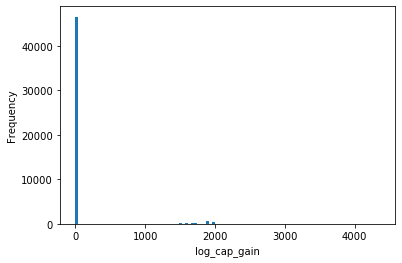

In [59]:
# Yeah pretty bad. Time to visualize:

x = data_original[feature_name]
pl.hist(x, bins=100)
pl.xlabel('log_cap_gain')
pl.ylabel('Frequency')

In [60]:
# I know the max value, it's definitly an outlier. Let's invetigate for others.

data_original.nlargest(10, [feature_name]) 

workclass      education  marital-status          occupation  \
8963      Private        HS-grad         Widowed      Prof-specialty   
14756     Private        HS-grad         Widowed     Exec-managerial   
30781     Private   Some-college         Widowed      Prof-specialty   
20416     Private        7th-8th        Divorced   Machine-op-inspct   
23802     Private   Some-college       Separated      Prof-specialty   
11902     Private        HS-grad        Divorced       Other-service   
15942     Private           10th       Separated        Adm-clerical   
9303      Private      Bachelors        Divorced        Adm-clerical   
12770     Private        HS-grad   Never-married        Adm-clerical   
12600   State-gov      Doctorate   Never-married      Prof-specialty   

          relationship    race      sex  cap-loss  hrsperwk          native  \
8963     Not-in-family   White   Female      4356        40   United-States   
14756    Not-in-family   White   Female      4356        18   United-States   
30781        Unmarried   Black   Female      4356        40   United-States   
20416        Unmarried   White   Female      3900        40   United-States   
23802        Own-child   White   Female      3900        40   United-States   
11902        Unmarried   White   Female      3770        45   United-States   
15942        Unmarried   White     Male      3770        40   United-States   
9303         Unmarried   White     Male      3770        40   United-States   
12770        Unmarried   White   Female      3770        37     Puerto-Rico   
12600   Other-relative   White   Female      3683        20   United-States   

        label  log_age_ZCentered  log_fnl_wgt_ZCentered  \
8963    <=50K           2.513692              -1.158342   
14756   <=50K           2.256355              -0.294576   
30781   <=50K           1.656308               0.239181   
20416   <=50K           1.101579              -0.207654   
23802   <=50K           0.340238               0.797794   
11902   <=50K          -0.177285               0.482034   
15942   <=50K           0.130184              -0.096004   
9303    <=50K           0.997251              -0.650104   
12770   <=50K          -0.432639               0.962249   
12600    >50K           1.972581              -0.936301   

       education_num_ZCentered cap-gains50k  log_cap_gain_ZCentered  
8963                 -0.419335        False               -0.297918  
14756                -0.419335        False               -0.297918  
30781                -0.030373        False               -0.297918  
20416                -2.364144        False               -0.297918  
23802                -0.030373        False               -0.297918  
11902                -0.419335        False               -0.297918  
15942                -1.586221        False               -0.297918  
9303                  1.136512        False               -0.297918  
12770                -0.419335        False               -0.297918  
12600                 2.303397        False               -0.297918

Text(0, 0.5, 'Frequency')

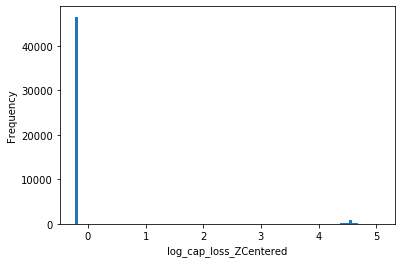

In [61]:
# These all look proper. I'll apply the same transformation to this as I did on cap-gain to keep it consistently scaled with the rest of our features.

log_cap_loss = np.log(data_original[feature_name] + 1)

mean = np.mean(log_cap_loss)
stdev = np.std(log_cap_loss)
log_cap_loss_ZCentered = (log_cap_loss - mean) / stdev

# Visualizing:
x = log_cap_loss_ZCentered
pl.hist(x, bins=100)
pl.xlabel('log_cap_loss_ZCentered')
pl.ylabel('Frequency')

In [62]:
# Now to replace the original feature with the transformed version.

data_original['log_cap_loss_ZCentered'] = log_cap_loss_ZCentered

# Deleting the original:
del data_original[feature_name]

# Checking:
data_original.head()

workclass   education       marital-status          occupation  \
0          State-gov   Bachelors        Never-married        Adm-clerical   
1   Self-emp-not-inc   Bachelors   Married-civ-spouse     Exec-managerial   
2            Private     HS-grad             Divorced   Handlers-cleaners   
3            Private        11th   Married-civ-spouse   Handlers-cleaners   
4            Private   Bachelors   Married-civ-spouse      Prof-specialty   

     relationship    race      sex  hrsperwk          native   label  \
0   Not-in-family   White     Male        40   United-States   <=50K   
1         Husband   White     Male        13   United-States   <=50K   
2   Not-in-family   White     Male        40   United-States   <=50K   
3         Husband   Black     Male        40   United-States   <=50K   
4            Wife   Black   Female        40            Cuba   <=50K   

   log_age_ZCentered  log_fnl_wgt_ZCentered  education_num_ZCentered  \
0           0.201990              -1.148845                 1.136512   
1           0.888830              -1.034554                 1.136512   
2           0.130184               0.473106                -0.419335   
3           1.049907               0.607470                -1.197259   
4          -0.714005               1.187445                 1.136512   

  cap-gains50k  log_cap_gain_ZCentered  log_cap_loss_ZCentered  
0        False                2.844559               -0.221264  
1        False               -0.297918               -0.221264  
2        False               -0.297918               -0.221264  
3        False               -0.297918               -0.221264  
4        False               -0.297918               -0.221264

In [63]:
# Good.

#######################################################################################################################################################

### **hrsperwk**    /Continuous. 

Meaning: The number of hours an individual works per week.

In [64]:
feature_name = 'hrsperwk'

# viewing a summary
data_original[[feature_name]].describe()

hrsperwk
count  48842.000000
mean      40.422382
std       12.391444
min        1.000000
25%       40.000000
50%       40.000000
75%       45.000000
max       99.000000

In [65]:
# Mean is about 40 hours, as expected. The first and third quartile are pretty tight to the mean so we'll likely see high kurtosis here. Probably some minor right skew too.
# I'll check skewness and kurtosis, as well as for missing values:

print(f'Skewness: {skew(data_original[feature_name])}')
print(f'Kurtosis: {kurtosis(data_original[feature_name])}')

boolseries = data_original.apply(lambda x: True if x[feature_name] == ' ?' else False, axis=1)
print(f'Number of missing values (?): {len(boolseries[boolseries == True].index)}')
print(f'Number of null values: {data_original[[feature_name]].isnull().sum()}')

Skewness: 0.2387423248342843
Kurtosis: 2.950634153321035
Number of missing values (?): 0
Number of null values: hrsperwk    0
dtype: int64


Text(0, 0.5, 'Frequency')

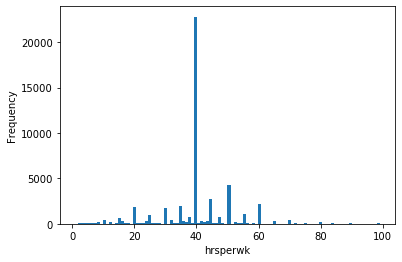

In [66]:
# Yup. Glad there aren't missing values.
# Let's visualize:

x = data_original[feature_name]
pl.hist(x, bins=100)
pl.xlabel('hrsperwk')
pl.ylabel('Frequency')

In [67]:
# I'll just Z-center this one to scale it properly. The skewness here isn't that extreme.

mean = np.mean(data_original[feature_name])
stdev = np.std(data_original[feature_name])
hrs_per_wk_ZCentered = (data_original[feature_name] - mean) / stdev

# Now to replace the original feature with the transformed version.

data_original['hrs_per_wk_ZCentered'] = hrs_per_wk_ZCentered

# Deleting the original:
del data_original[feature_name]

# Checking:
data_original.head()

workclass   education       marital-status          occupation  \
0          State-gov   Bachelors        Never-married        Adm-clerical   
1   Self-emp-not-inc   Bachelors   Married-civ-spouse     Exec-managerial   
2            Private     HS-grad             Divorced   Handlers-cleaners   
3            Private        11th   Married-civ-spouse   Handlers-cleaners   
4            Private   Bachelors   Married-civ-spouse      Prof-specialty   

     relationship    race      sex          native   label  log_age_ZCentered  \
0   Not-in-family   White     Male   United-States   <=50K           0.201990   
1         Husband   White     Male   United-States   <=50K           0.888830   
2   Not-in-family   White     Male   United-States   <=50K           0.130184   
3         Husband   Black     Male   United-States   <=50K           1.049907   
4            Wife   Black   Female            Cuba   <=50K          -0.714005   

   log_fnl_wgt_ZCentered  education_num_ZCentered cap-gains50k  \
0              -1.148845                 1.136512        False   
1              -1.034554                 1.136512        False   
2               0.473106                -0.419335        False   
3               0.607470                -1.197259        False   
4               1.187445                 1.136512        False   

   log_cap_gain_ZCentered  log_cap_loss_ZCentered  hrs_per_wk_ZCentered  
0                2.844559               -0.221264             -0.034087  
1               -0.297918               -0.221264             -2.213032  
2               -0.297918               -0.221264             -0.034087  
3               -0.297918               -0.221264             -0.034087  
4               -0.297918               -0.221264             -0.034087

#######################################################################################################################################################

### **native**    /Categorical. Factor Levels include: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

Meaning: The country the individual was born in.

In [68]:
feature_name = 'native'

# viewing a summary
data_original[[feature_name]].describe()

native
count            48842
unique              42
top      United-States
freq             43832

In [69]:
# Our summary tells us there are 42 unique factor levels here. However, there are only 41 listed in the description, so we have missing values. Most common value is United-states
# Confirming:

boolseries = data_original.apply(lambda x: True if x[feature_name] == ' ?' else False, axis=1)
print(f'Number of missing values (?): {len(boolseries[boolseries == True].index)}')
print(f'Number of null values: {data_original[[feature_name]].isnull().sum()}')

Number of missing values (?): 857
Number of null values: native    0
dtype: int64


In [70]:
# I'll impute the mode (United-States) for the missing values.

data_original.groupby(feature_name).count()

# Making the replacement and recalculating the values
data_original[[feature_name]] = data_original[[feature_name]].replace([" ?"], [" United-States"])
data_original.groupby(feature_name).count()

# Worked fine.

workclass  education  marital-status  occupation  \
native                                                                          
 Cambodia                           28         28              28          28   
 Canada                            182        182             182         182   
 China                             122        122             122         122   
 Columbia                           85         85              85          85   
 Cuba                              138        138             138         138   
 Dominican-Republic                103        103             103         103   
 Ecuador                            45         45              45          45   
 El-Salvador                       155        155             155         155   
 England                           127        127             127         127   
 France                             38         38              38          38   
 Germany                           206        206             206         206   
 Greece                             49         49              49          49   
 Guatemala                          88         88              88          88   
 Haiti                              75         75              75          75   
 Holand-Netherlands                  1          1               1           1   
 Honduras                           20         20              20          20   
 Hong                               30         30              30          30   
 Hungary                            19         19              19          19   
 India                             151        151             151         151   
 Iran                               59         59              59          59   
 Ireland                            37         37              37          37   
 Italy                             105        105             105         105   
 Jamaica                           106        106             106         106   
 Japan                              92         92              92          92   
 Laos                               23         23              23          23   
 Mexico                            951        951             951         951   
 Nicaragua                          49         49              49          49   
 Outlying-US(Guam-USVI-etc)         23         23              23          23   
 Peru                               46         46              46          46   
 Philippines                       295        295             295         295   
 Poland                             87         87              87          87   
 Portugal                           67         67              67          67   
 Puerto-Rico                       184        184             184         184   
 Scotland                           21         21              21          21   
 South                             115        115             115         115   
 Taiwan                             65         65              65          65   
 Thailand                           30         30              30          30   
 Trinadad&Tobago                    27         27              27          27   
 United-States                   44689      44689           44689       44689   
 Vietnam                            86         86              86          86   
 Yugoslavia                         23         23              23          23   

                             relationship   race    sex  label  \
native                                                           
 Cambodia                              28     28     28     28   
 Canada                               182    182    182    182   
 China                                122    122    122    122   
 Columbia                              85     85     85     85   
 Cuba                                 138    138    138    138   
 Dominican-Republic                   103    103    103    103   
 Ecuador         

#######################################################################################################################################################

### **Checking for numeric feature correlation**

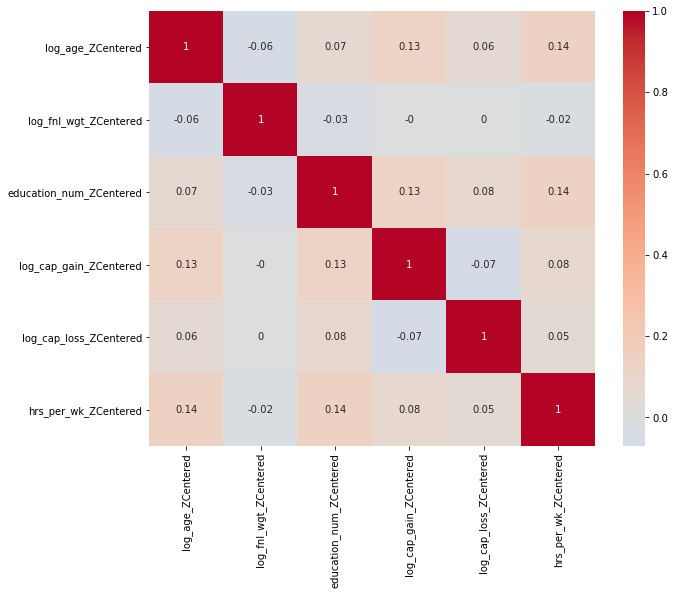

In [71]:
# Checking correlation between all numeric features.

correlation_matrix = data_original.corr().round(2)
pl.figure(figsize=(10,8))
sb.heatmap(data=correlation_matrix, annot=True, center=0.0, cmap='coolwarm')

In [72]:
# Our numeric features have very weak correlation to eachother. This is good for us if we're looking to predict our label because it means we won't have to worry 
# about the preoblem of multicollinearity. 

#######################################################################################################################################################

### **Investigating explainable variation between non-label categorical features**

Features to look at here [workclass, education, marital-status, occupation, relationship, race, sex, cap-gains50k]

Pairs of categorical variables don't have a pearson correlation coefficient.

To explore whether one categorical group effects the distribution of another, I'll be making interaction plots. The plots will consist of lines marking the change in
frequency from one categorical factor level to another. There will be a set of lines per factor level of the second categorical varaible.
Generally when the lines between the factor levels controlling the hue are approximatly paralell this means that the second variable is not really effecting the distribution 
of the first. Otherwise, there may be an interesting effect. In such cases I'll try to explain the interaction or raise questions regarding it.

I'll be skipping interactions with the feature (native) because of the high volume of factor levels. This type of plot will just be confusing with too many levels.

I'll also omit any plots that appear to exhibit little interaction for the sake of brevity.

Text(0.5, 0.98, 'Interaction of education ~ workclass')

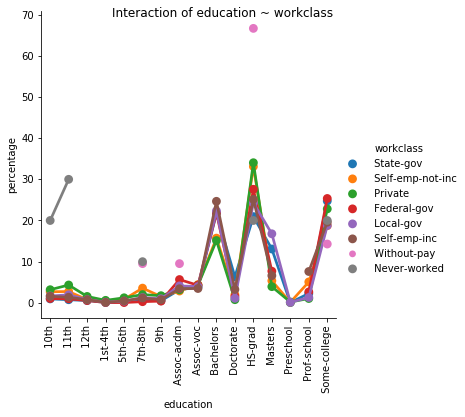

In [73]:
# Each graph will be created with the same code, I'll just switch the names of the variables hue_lab and x_lab
hue_lab = 'workclass'
x_lab = 'education'

# Grouping by the hue_group, then counting by the x_lab group
hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)

# Creating the percentage vector to measure the frequency of each type
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]

# Creating and plotting the new dataframe 
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

The interaction between education and workclass shows a higher percentage of 'HS-grad' individuals in the occupation 'Without-pay' than all the other 'HS-grad' individuals.
There also appear to be more individuals than average who have completed HS or less that are 'Without-pay' or 'Never-worked' than other education groups.

Text(0.5, 0.98, 'Interaction of occupation ~ workclass')

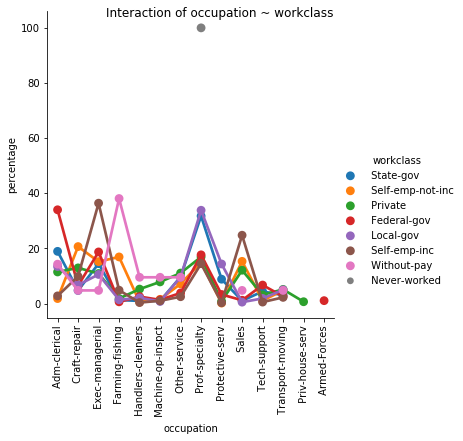

In [74]:
hue_lab = 'workclass'
x_lab = 'occupation'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

There is a lot of variation here within these groups. This may be explained by some occupations being available at different frequencies within different economic sectors. One of which, that is rather extreme, is the armed forces only being a part of the federal government.

Text(0.5, 0.98, 'Interaction of workclass ~ cap-gains50k')

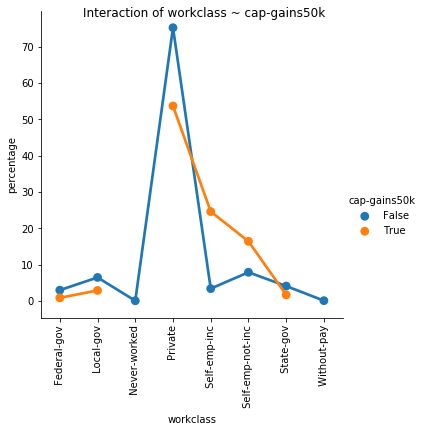

In [75]:
hue_lab = 'cap-gains50k'
x_lab = 'workclass'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

Here's something interesting, some variation in frequency occuring in the rates of 'cap-gains50k' based on economic sector. Seeing greater frequency of 'cap-gains50k' for individuals that are self employed. This could result from these individuals making less consistent pay than the other factor levels of workclass, thus taking more risk in equities. Or it could also be the result of these individuals making more money than others, due to having a greater share of profit. Higher principle risked on average provides higher return in markets.

Text(0.5, 0.98, 'Interaction of education ~ cap-gains50k')

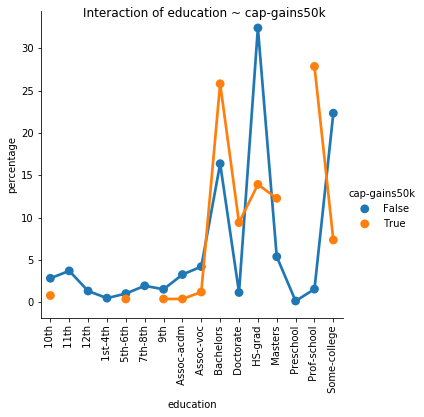

In [76]:
hue_lab = 'cap-gains50k'
x_lab = 'education'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

There's a lot of variation here. In advanced degrees such as prof-school, bachelors, masters, and doctorate individuals have a higher frequency of cap-gains50k being True than False. All other education levels are the opposite. This could be because these degree holders have a hgiher access to capital than the others, due to having better job oppotunities. 

Text(0.5, 0.98, 'Interaction of occupation ~ marital-status')

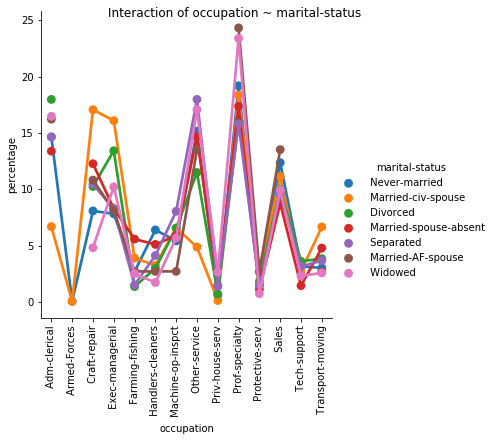

In [77]:
hue_lab = 'marital-status'
x_lab = 'occupation'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

This graph is somewhat interesting. Occupations on the right side of the x-axis appear very paralell, where occupations on the left side of the x-axis appear much more mixed. I don't really have any idea why this is occurring.

Text(0.5, 0.98, 'Interaction of marital-status ~ relationship')

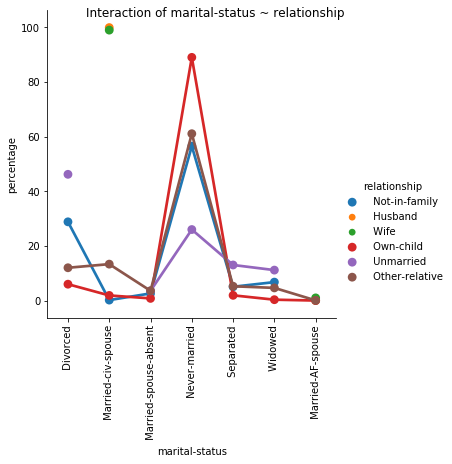

In [78]:
hue_lab = 'relationship'
x_lab = 'marital-status'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

This interaction isn't all that interesting. I only left it in because of one small detail. The levels of relationship 'Husband' and 'wife' are almost perfectly matched to the factor level 'Married-civ-spouse' in marital-status. These levels essentially describe the same thing and we may want to exclude one the two features from our final model.

Text(0.5, 0.98, 'Interaction of marital-status ~ sex')

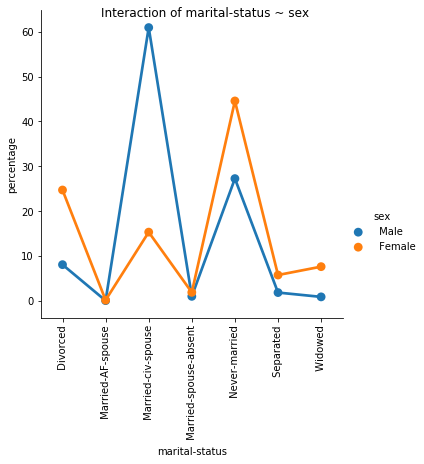

In [79]:
hue_lab = 'sex'
x_lab = 'marital-status'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

Here, our data seems to imply that American men are much more likely to be married than american women. Also, women have a higher percentage of diverce than men. Perhaps the two are connected? Perhaps not? Women are also more liekly to have never been married which may also contribute.

Text(0.5, 0.98, 'Interaction of marital-status ~ cap-gains50k')

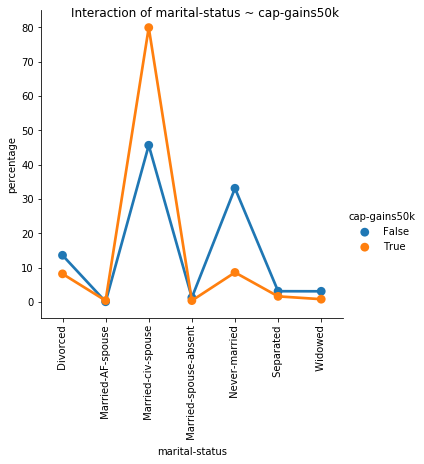

In [80]:
hue_lab = 'cap-gains50k'
x_lab = 'marital-status'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

This interaction exhibits something a lot of people might expect. Married individuals have a significantly hgiher percentage of cap-gains50k being True than False. Most likely due to two people being able to contribute more capital than one. Also, individuals never-married have significantly lower percentage of cap-gains50k being True than False. For the same reason as previous.

Text(0.5, 0.98, 'Interaction of occupation ~ relationship')

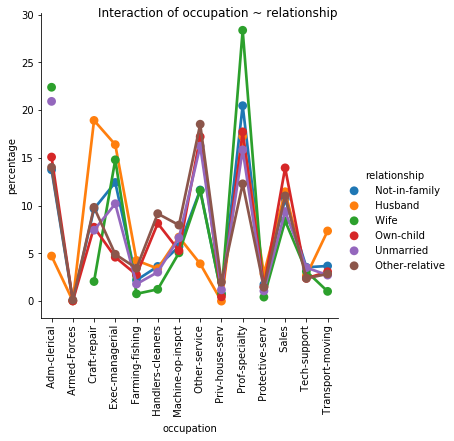

In [81]:
hue_lab = 'relationship'
x_lab = 'occupation'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

This interaction shows a lot of the same variation that we saw in the occupation ~ marital-status interation. I'm beleiving more and more that marital-status and relationship are a bit redundant.

Text(0.5, 0.98, 'Interaction of occupation ~ sex')

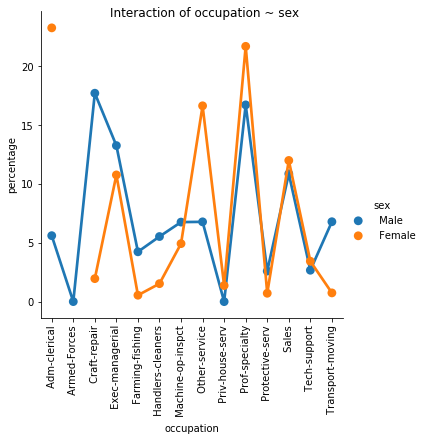

In [82]:
hue_lab = 'sex'
x_lab = 'occupation'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

This interactions displays the idea that men and women often tend to work in different fields. Especially so in the 'adm-clerical' and 'craft-repair' factor levels. The court is still out on whether this is due to socially constructed entry barriers or that men and women tend to prefer focusing on different thing on average.

Text(0.5, 0.98, 'Interaction of occupation ~ cap-gains50k')

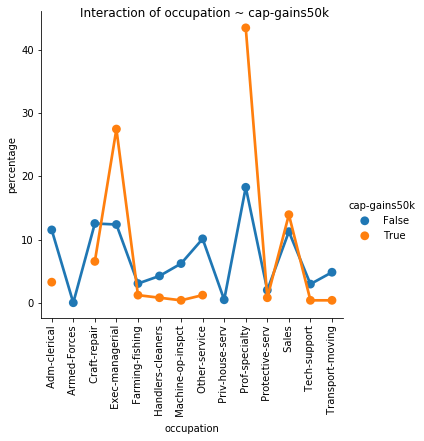

In [83]:
hue_lab = 'cap-gains50k'
x_lab = 'occupation'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

Here we see that occupation likely has a lot of influence over whether a person makes capital gains greater than 50k in a year. Occupations with the largest disparity between cap-gains50k being True or False are 'Exec-managerial' and 'Prof-specialty'.

Text(0.5, 0.98, 'Interaction of relationship ~ race')

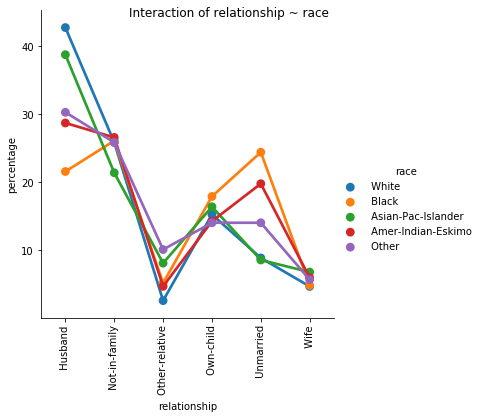

In [84]:
hue_lab = 'race'
x_lab = 'relationship'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

Something interesting is definitly happening here. Race appears to effect whether an individual is a husband or Unmarried. The 'wife' designation doesn't show this effect much. All of the wife observations are very close to eachother racially. Yet, 'husband' and 'unmarried' have wider variation and an almost preserved ordering, suggesting a lack of 'black' 'husband' individuals may influence a gain in 'black' 'unmarried' individuals.

Text(0.5, 0.98, 'Interaction of relationship ~ sex')

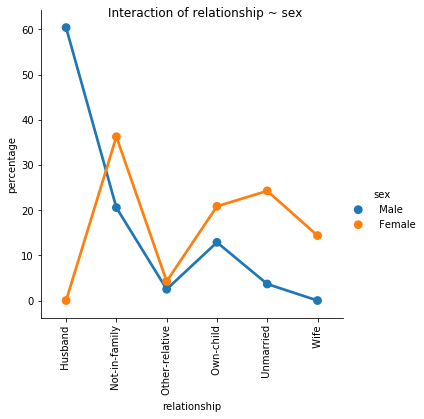

In [85]:
hue_lab = 'sex'
x_lab = 'relationship'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

Disregard the disparities here in the 'Husband' and 'wife' relationship designations, these are dependent on sex. The most interesting effect here is that women appear more likely to be an 'only child' or 'unmarried'.

Text(0.5, 0.98, 'Interaction of relationship ~ cap-gains50k')

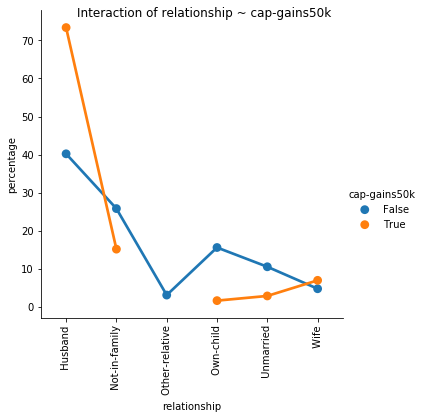

In [86]:
hue_lab = 'cap-gains50k'
x_lab = 'relationship'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

Here we see that 'husband' and 'wife' individuals are more likely to have capital gains greater than 50k. Likely, a repeat of the effect we saw earlier that I attributed to married individuals having reater access to capital on average.

Text(0.5, 0.98, 'Interaction of sex ~ cap-gains50k')

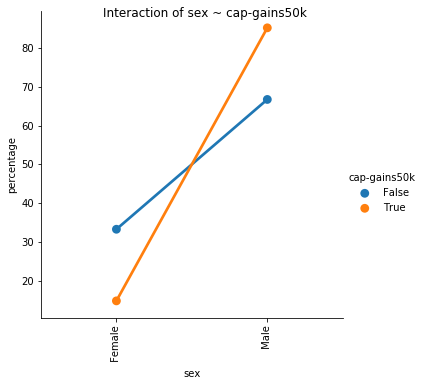

In [87]:
hue_lab = 'cap-gains50k'
x_lab = 'sex'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

Why does it appear that men are more likely to have capital gains greater than 50k than women? Are men more aggressive with investments on average? Is it due to men being more likely to be married? Other socio-economic factors?

#######################################################################################################################################################

### **Investigating explainable variation between non-label categorical features and numerical features**

Features to look at here: Continuous[log_age_ZCentered, log_fnl_wgt_ZCentered, education_num_ZCentered, log_cap_gain_ZCentered, log_cap_loss_ZCentered, hrs_per_wk_ZCentered] ~ Categorical[workclass, education, marital-status, occupation, relationship, race, sex, cap-gains50k]

I'll be skipping interactions with the feature (native) because of the high volume of factor levels. Plots will just be confusing with too many levels.

There will be 48 total pairs here to represent with plots so, again, I'll also omit any plots that appear to exhibit little interaction for the sake of brevity.

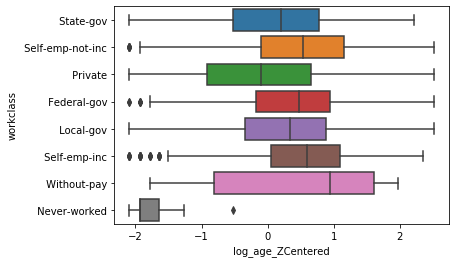

In [88]:
sb.boxplot( x=data_original["log_age_ZCentered"], y=data_original["workclass"] )

Here we see younger than average individuals mostly make up the never-worked factor level.

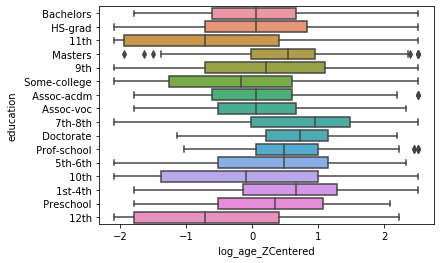

In [89]:
sb.boxplot( x=data_original["log_age_ZCentered"], y=data_original["education"] )

Age effects the degree of education an individual has completed. Somewhat a given, but worth noting.

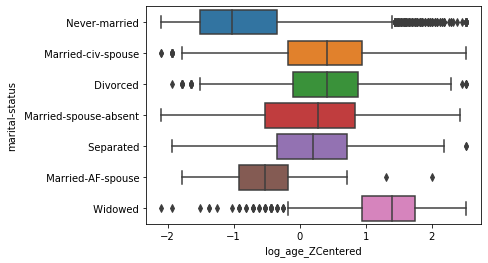

In [90]:
sb.boxplot( x=data_original["log_age_ZCentered"], y=data_original["marital-status"] )

Age also effects marital-status. We see younger individuals making up the majority of 'never-married' individuals. We see older individuals making up the mojority of the 'Widowed' factor level.

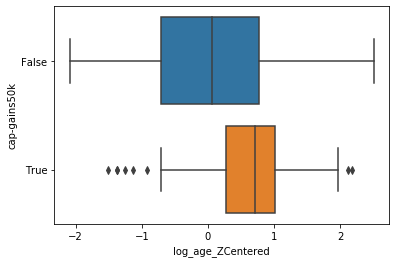

In [91]:
sb.boxplot( x=data_original["log_age_ZCentered"], y=data_original["cap-gains50k"] )

The average age on individuals making less than 50k in capital gains is lower than the average age of those making more than 50k in capital gains. The variance of the less than 50k sample is also much wider than the other sample. This makes sense because older individuals have more access to capital and can achieve higher dollar value gains with the same percentage increase in portfolio value.

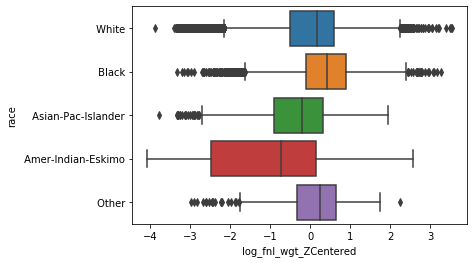

In [92]:
sb.boxplot( x=data_original["log_fnl_wgt_ZCentered"], y=data_original["race"] )

Here we can get a bit of a clue into how racial descriminators effect the value of the final weight feature. American-Indian-Exkimos have a slightly lower average than the other racial groups, but a much lower first quartile than the other racial groups. I still don't know how the authors calculated this statistic so I don't know why this is.

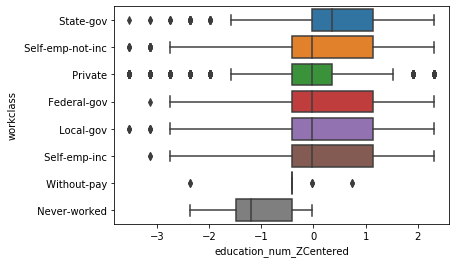

In [93]:
sb.boxplot( x=data_original["education_num_ZCentered"], y=data_original["workclass"] )

Mostly less educated individuals appear to make up the 'never-worked' factor level. As we have already attributed younger individuals to the never worked category and to the lower education category, we're likely seeing the same effect here.

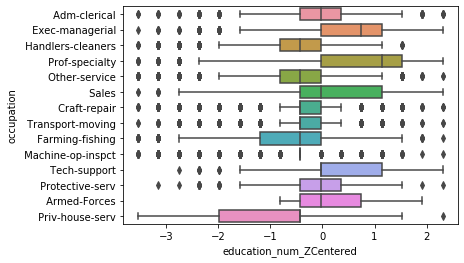

In [94]:
sb.boxplot( x=data_original["education_num_ZCentered"], y=data_original["occupation"] )

Years of education completed has a noticable effect on the variation of the 'occupation' feature. Some jobs have higher barriers to entry than others.

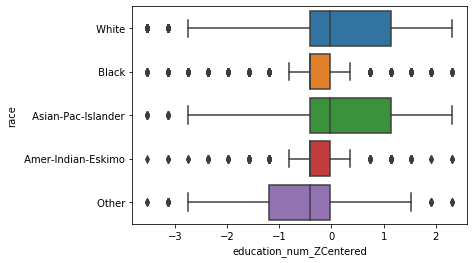

In [95]:
sb.boxplot( x=data_original["education_num_ZCentered"], y=data_original["race"] )

The distribution of education years completed appears to change noticably when factored by race. All of the education distributions have similar a mean (likely around graduating from HS) but the thrid quartiles for whites and asians are higher than the remaining races. The other category has a lower first quartile than the remaining distributions. There are outliers in all categories. This effecty is likely due to some socio-economic factors within these communities.

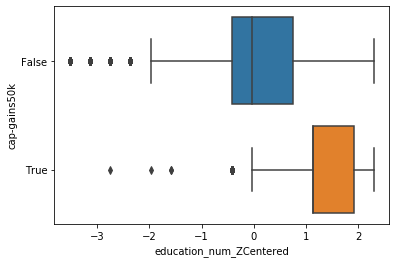

In [96]:
sb.boxplot( x=data_original["education_num_ZCentered"], y=data_original["cap-gains50k"] )

Here we see that more educated individuals are much more likely than less educated individuals to achieve greater than 50k in capital gains. Probably due to more educated individuals on average being more specialized and paid more.

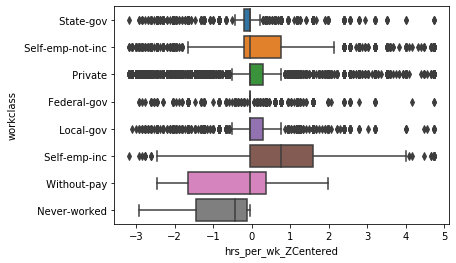

In [97]:
sb.boxplot( x=data_original["hrs_per_wk_ZCentered"], y=data_original["workclass"] )

Here we see a bit of variation between the hours worked per week within different economic sectors. Self employed individuals work more than average and 'without-pay' + 'Never-worked' individuals work much less than average. The remaining groups have similar distributions with many outliers. 

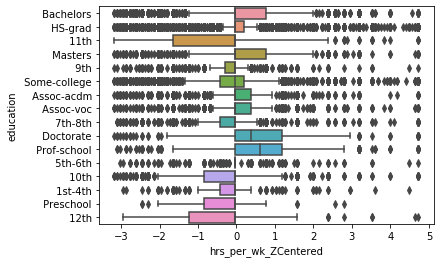

In [98]:
sb.boxplot( x=data_original["hrs_per_wk_ZCentered"], y=data_original["education"] )

College educated individuals and Prof-school individuals appear to work more hours than the average when compared to all other groups. Is this because these groups are on average tackling more complex problems? Is this because these groups are in positions requiring more responsibility, and thus, more time?

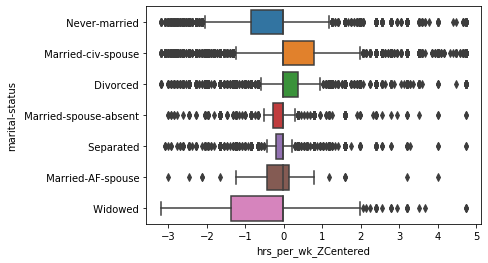

In [99]:
sb.boxplot( x=data_original["hrs_per_wk_ZCentered"], y=data_original["marital-status"] )

Hours worked per week also avaries noticable based on the marital-status of an individual. While all of these factor levels show a similar mean, the first and third quartiles are where we see the effect. Widowed individuals work less than the mean of all groups, likely due to being older on average and perhaps retired. Never married individuals also work less than the shared mean. (perhaps this contributes to why they were never married. Married individuals work slightly more hours than divorced inidividuals for unkown reasons.

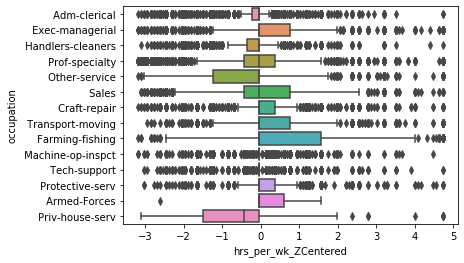

In [100]:
sb.boxplot( x=data_original["hrs_per_wk_ZCentered"], y=data_original["occupation"] )

Here we see how some occupations simply require more time than others, especially farming for example. We all know the common trope of the farmer waking up at the crack of dawn to manage the fields. Is this what the data is showing us?

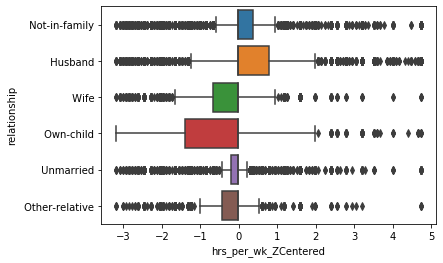

In [101]:
sb.boxplot( x=data_original["hrs_per_wk_ZCentered"], y=data_original["relationship"] )

The most interesting variation between these 'relationship' groups is that husband work on average more hours per week than wives. Is this due to the effect of child rearing? The 'own-child' factor level shows lower hours worked per week than the everage of the rest of the groups. Is this because most of these individuals are younger?

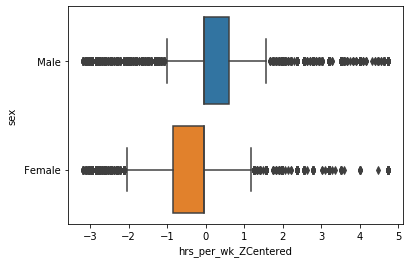

In [102]:
sb.boxplot( x=data_original["hrs_per_wk_ZCentered"], y=data_original["sex"] )

Again, we're seeing that men on average work more hours than women. Again, is this because of the effect of child rearing on the average?

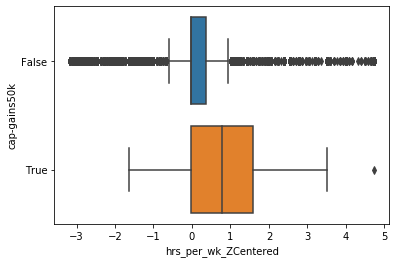

In [103]:
sb.boxplot( x=data_original["hrs_per_wk_ZCentered"], y=data_original["cap-gains50k"] )

Those who work more hours per week appear more likely to achieve grater than 50k of capital gains. Is this because longer hours worked achieves higher pay and more access to capital?

#######################################################################################################################################################

### **Investigating explainable variation between the label and predictor features**

Here, we'll be investigating the relationships between the label and [log_age_ZCentered, log_fnl_wgt_ZCentered, education_num_ZCentered, log_cap_gain_ZCentered, log_cap_loss_ZCentered, hrs_per_wk_ZCentered, workclass, education, marital-status, occupation, relationship, race, sex, cap-gains50k]

I'll be using a combination of the same plots from the last two sections.

I won't omit any plot from this section because there are only 14 of them.

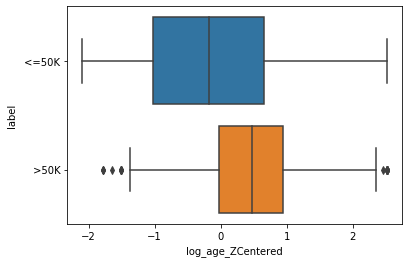

In [104]:
sb.boxplot( x=data_original["log_age_ZCentered"], y=data_original["label"] )

It appears older individuals making > 50k are on average older than the average individual in the sample. Just as we've seen with the cap-gains50k distribution. This is likely due to older individuals being in more senior positions that pay more.

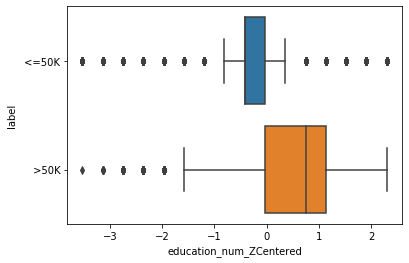

In [105]:
sb.boxplot( x=data_original["education_num_ZCentered"], y=data_original["label"] )

Individuals making > 50k have higher than average years of education completed. The mean of the <= 50k group appears almost and entire standard deviation lower and the variances of the two groups appear significantly different.

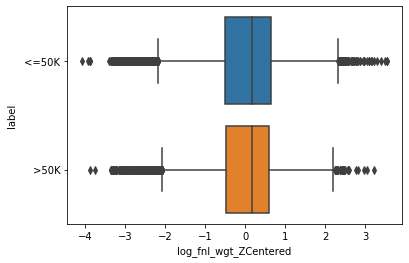

In [106]:
sb.boxplot( x=data_original["log_fnl_wgt_ZCentered"], y=data_original["label"] )

The distributions of the two final weight groups here are very similar. It's likely I wouldn't use this in a predictive model given that thte label was our target. 

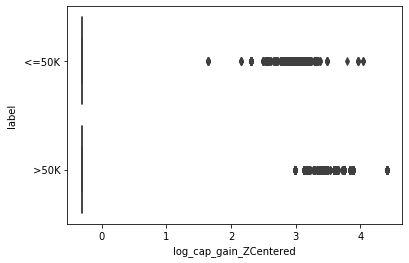

In [107]:
sb.boxplot( x=data_original["log_cap_gain_ZCentered"], y=data_original["label"] )

The average, first & third quartiles, and tails of the two capital gains groups here are all basically 0. This is why I made a categorical feature off of this numeric feature. The distribution of the > 50k outlier appears more concentrated higher than the <= 50k outliers. 

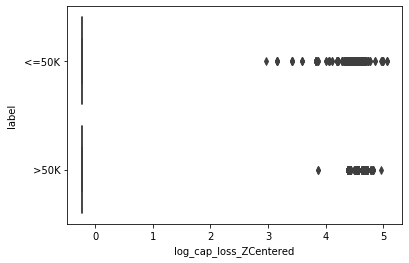

In [108]:
sb.boxplot( x=data_original["log_cap_loss_ZCentered"], y=data_original["label"] )

Very similar distributions in capital loss as with capital gain. We see higher magnitude gain/loss in the >50k column because of greater dollar value gain on the same percent increase of a likely larger thasn average pool of capital. 

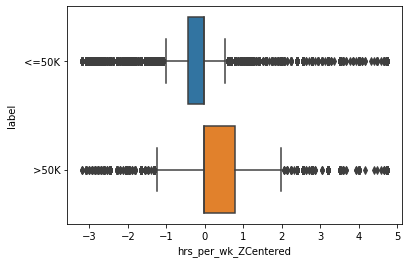

In [109]:
sb.boxplot( x=data_original["hrs_per_wk_ZCentered"], y=data_original["label"] )

The > 50k group here shows a higher average number of hours worked per week than the <= 50k group. Both distributions have pretty tight quartiles and have many outliers. 

Text(0.5, 0.98, 'Interaction of workclass ~ label')

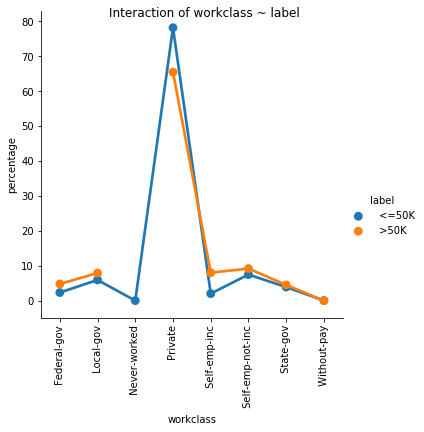

In [110]:
hue_lab = 'label'
x_lab = 'workclass'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

There's some interaction here. The percentage of individuals making > 50k is higher in all factor levels except for 'Private' and 'never-worked'. Could be useful. I would have expected private workers to have the advantage here. I don't know how this works . . .

Text(0.5, 0.98, 'Interaction of education ~ label')

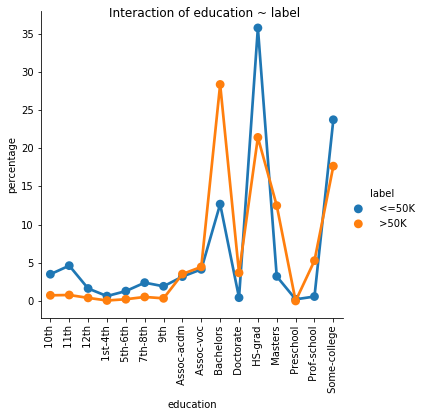

In [111]:
hue_lab = 'label'
x_lab = 'education'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

Again, similar to the interaction between education ~ cap-gains50k, we see advanced degrees such as 'Prof-school', 'Bachelors', 'Masters', & 'Doctorate' having the advantage here. Pretty significant difference in the proportions at these levels.

Text(0.5, 0.98, 'Interaction of marital-status ~ label')

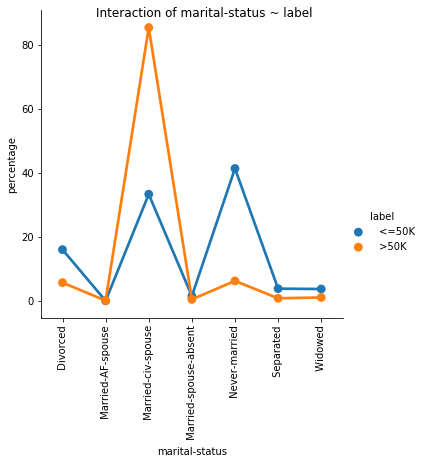

In [112]:
hue_lab = 'label'
x_lab = 'marital-status'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

Again, we see greater financial succes with married individuals. Joint income is powerful. We also see a higher frequency of <= 50k individuals under the 'Never-married' factor level.

Text(0.5, 0.98, 'Interaction of occupation ~ label')

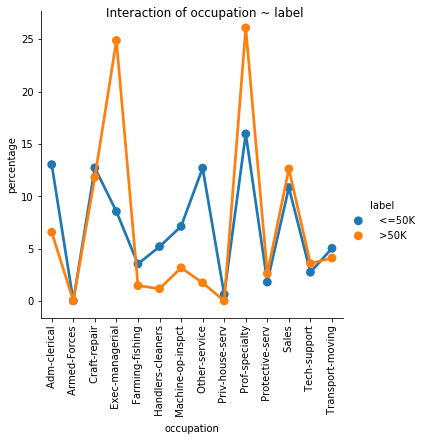

In [113]:
hue_lab = 'label'
x_lab = 'occupation'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

Occupation levels provide a lot of variation in frequency regarding our label. The two best off occupation levels are 'Prof-specialty' and 'Exec-managerial'. Likely due to higher than average pay.

Text(0.5, 0.98, 'Interaction of relationship ~ label')

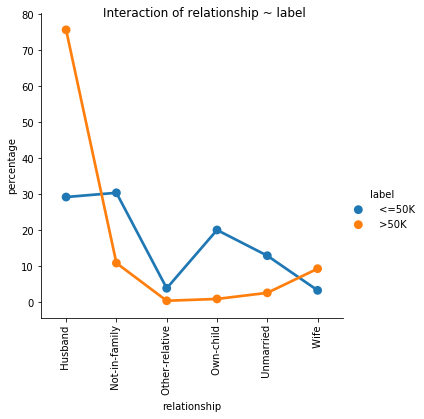

In [114]:
hue_lab = 'label'
x_lab = 'relationship'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

Individuals that're Husband or wives, again, appear better off. Liekly another redundant effec that we've seen under the 'marital-status ~ label' interaction.

Text(0.5, 0.98, 'Interaction of race ~ label')

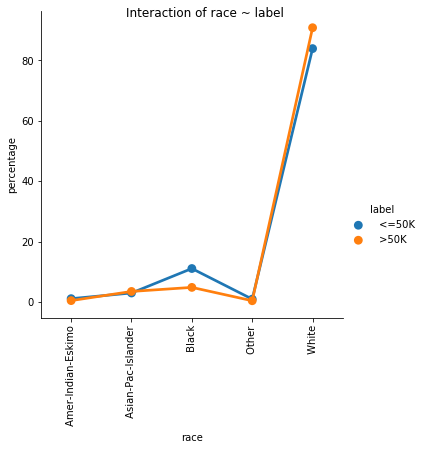

In [115]:
hue_lab = 'label'
x_lab = 'race'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

This interaction doesn't appear to be especially interesting for all races except black individuals, whom unfortunatly have a higher frequency of making less than 50k. The remaining racial groups are all very similar.

Text(0.5, 0.98, 'Interaction of sex ~ label')

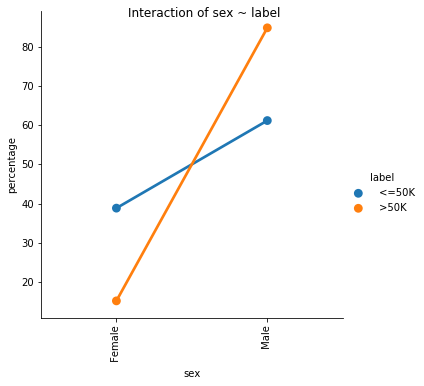

In [116]:
hue_lab = 'label'
x_lab = 'sex'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

This graph is almost identical to the relationship 'sex ~ cap-gains50k'. We, again, see men being more likely to make more than 50k than women. Likely, attributable to the effect of child rearing on average.

Text(0.5, 0.98, 'Interaction of label ~ cap-gains50k')

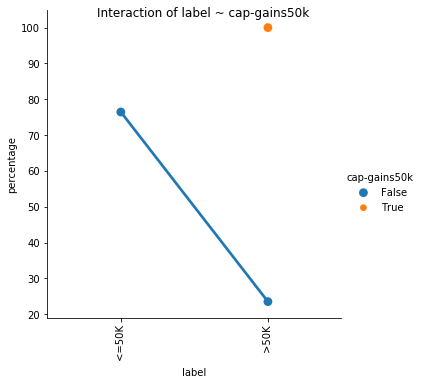

In [119]:
hue_lab = 'cap-gains50k'
x_lab = 'label'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

All individuals making capital gains greater than 50k end the year with the label >50k. (This is why I made this feature) Roughly 20% of individuals making less than 50k in capital gains still make >50k, so this won't be the only feature we need to predict the label.

#######################################################################################################################################################

# ***Summary of findings after EDA***

In [118]:
# Final data set
data_original.head()

workclass   education       marital-status          occupation  \
0          State-gov   Bachelors        Never-married        Adm-clerical   
1   Self-emp-not-inc   Bachelors   Married-civ-spouse     Exec-managerial   
2            Private     HS-grad             Divorced   Handlers-cleaners   
3            Private        11th   Married-civ-spouse   Handlers-cleaners   
4            Private   Bachelors   Married-civ-spouse      Prof-specialty   

     relationship    race      sex          native   label  log_age_ZCentered  \
0   Not-in-family   White     Male   United-States   <=50K           0.201990   
1         Husband   White     Male   United-States   <=50K           0.888830   
2   Not-in-family   White     Male   United-States   <=50K           0.130184   
3         Husband   Black     Male   United-States   <=50K           1.049907   
4            Wife   Black   Female            Cuba   <=50K          -0.714005   

   log_fnl_wgt_ZCentered  education_num_ZCentered cap-gains50k  \
0              -1.148845                 1.136512        False   
1              -1.034554                 1.136512        False   
2               0.473106                -0.419335        False   
3               0.607470                -1.197259        False   
4               1.187445                 1.136512        False   

   log_cap_gain_ZCentered  log_cap_loss_ZCentered  hrs_per_wk_ZCentered  
0                2.844559               -0.221264             -0.034087  
1               -0.297918               -0.221264             -2.213032  
2               -0.297918               -0.221264             -0.034087  
3               -0.297918               -0.221264             -0.034087  
4               -0.297918               -0.221264             -0.034087

I've kept all of the features of the original data set in order to preserve the information available when we begin modelling the data. (removed original representations of monotonically transformed numeric features)

Each numeric feature was transformed to the Z-score of the feature in order to have consistent scaling. Some models fail (especially those using gradient descent) if some features have much larger numbers than others. The features: 'age', 'fnlwgt', 'cap_gain', and 'cap_loss' were all transformed using the log function before they were scaled by the Z-score.

I created one new feature, 'cap-gain50k' which is a binary categorical feature. Its value is True if the individual made more than 50k in capital gains and False otherwise.

None of the outliers that I've observed appeared erroneous so I've left them as is. 

Missing values within a categorical feature were replaced with the mode value. Missing values within a numeric feature were replaced with the mean value.